# Simlep influence plots of IBM/non-IBM users
Author: Daheng Wang  
Last modified: 2017-05-28

# Roadmap
1. Query database and build pickle
2. Calculate simple influece measurement
3. Plot influences of IBM/non-IBM users

# Steps

In [1]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
Standard modules, MongoDB modules
'''
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

'''
Misc
'''
NB_NAME = '20170504-influence_plots'

## Query database and build pickle

We first calculate a simple influence measurement based on 
1. the 'retweet_count' field of tweet
2. the 'followers_count' field of user

The basic idea is we are looking for "popular users who can motivate others to engage in discussion".  
We use the 'followers_count' to represent the popularity of a user, and use the 'retweet_count' to represent the engagement level affected by the user.

We define: simple_influence = sum of retweet_count of native tweets over a user / (followers_count of user * number of native tweets)  
At the same time, we differentiate between normal/quote/reply tweets.

In [2]:
"""
Declare 4 tmp pickles
"""

'''
Pickle for ALL tweets grouped by 'user.id'
'''
simple_influence_native_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'simple_influence_native.lst.pkl')) 

'''
Pickle for only QUOTE tweets grouped by 'user.id'
'''
simple_influence_quote_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'simple_influence_quote.lst.pkl'))

'''
Pickle for only REPLY tweets grouped by 'user.id'
'''
simple_influence_reply_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'simple_influence_reply.lst.pkl'))

'''
Pickle for only NORMAL tweets grouped by 'user.id'
'''
simple_influence_normal_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'simple_influence_normal.lst.pkl'))

In [ ]:
"""
Build compound index 'user.id'-'id' on TW_NT_COL collection
"""
if 0 == 1:
    tw_nt_col = mongodb.initialize(DB_NAME, TW_NT_COL)
    tw_nt_col.create_index([("user.id", pymongo.ASCENDING),("id", pymongo.ASCENDING)], background=True)
    print('Done')

In [3]:
%%time
"""
Make simple_influence_native_pkl
"""
if 0 == 1:
    print('Making pickle from database...')
    data_lst = []
    
    # query on all native tweets
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'followers_count': {'$first': '$user.followers_count'}, # number of followers the user has
                             'nt_num': {'$sum': 1}, # total number of native tweets belongs to the user
                             'nt_sum_retweet_count': {'$sum': '$retweet_count'} # sum of retweet_count of all native tweets belong to the user
                             }}
    
    project_dict = {'$project': {'_id': 0,
                                 'user_id': '$_id',
                                 'followers_count': 1,
                                 'nt_num': 1,
                                 'nt_sum_retweet_count': 1}}
    
    ppl_lst = [group_dict, project_dict]
    
    print('Aggreating on collection "{}"'.format(TW_NT_COL))
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    cursor = tw_nt_col.aggregate(pipeline=ppl_lst,
                                 allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_native_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')

Making pickle from database...
Aggreating on collection "tw_nt"
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Done
CPU times: user 6.95 s, sys: 1.2 s, total: 8.15 s
Wall time: 1min 6s


In [4]:
%%time
"""
Make simple_influence_quote_pkl
"""
if 0 == 1:
    print('Making pickle from database...')
    data_lst = []
    
    # query only quote tweets
    match_dict = {'$match': {'quoted_status': {'$exists': True}}}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'qt_num': {'$sum': 1}, # number of quote tweets belongs to the user
                             'qt_sum_retweet_count': {'$sum': '$retweet_count'} # sum of retweet_count of all quote tweets belong to the user
                             }}

    project_dict = {'$project': {'_id': 0,
                                 'user_id': '$_id',
                                 'qt_num': 1,
                                 'qt_sum_retweet_count': 1}}
    
    ppl_lst = [match_dict, group_dict, project_dict]
    
    print('Aggreating on collection "{}"'.format(TW_NT_COL))
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    cursor = tw_nt_col.aggregate(pipeline=ppl_lst,
                                 allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_quote_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')

Making pickle from database...
Aggreating on collection "tw_nt"
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Done
CPU times: user 1.6 s, sys: 180 ms, total: 1.78 s
Wall time: 35.3 s


In [5]:
%%time
"""
Make simple_influence_reply_pkl
"""
if 0 == 1:
    print('Making pickle from database...')
    data_lst = []
    
    # query only reply tweets
    match_dict = {'$match': {'in_reply_to_status_id': {'$ne': None}}}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'pt_num': {'$sum': 1}, # total number of reply tweets belongs to the user
                             'pt_sum_retweet_count': {'$sum': '$retweet_count'} # sum of retweet_count of all reply tweets belong to the user
                             }}
    
    project_dict = {'$project': {'_id': 0,
                                 'user_id': '$_id',
                                 'pt_num': 1,
                                 'pt_sum_retweet_count': 1}}
    
    ppl_lst = [match_dict, group_dict, project_dict]
    
    print('Aggreating on collection "{}"'.format(TW_NT_COL))
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    cursor = tw_nt_col.aggregate(pipeline=ppl_lst,
                                 allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_reply_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')

Making pickle from database...
Aggreating on collection "tw_nt"
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Done
CPU times: user 576 ms, sys: 56 ms, total: 632 ms
Wall time: 30.5 s


In [6]:
%%time
"""
Make simple_influence_normal_pkl
"""
if 0 == 1:
    print('Building pickle from database...')
    data_lst = []
    
    # query only normal tweets
    match_dict = {'$match': {'quoted_status': {'$exists': False}, # not a quote
                             'in_reply_to_status_id': {'$eq': None} # not a reply
                            }}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'nrt_num': {'$sum': 1}, # total number of normal tweets belongs to the user
                             'nrt_sum_retweet_count': {'$sum': '$retweet_count'} # sum of retweet_count of all normal tweets belong to the user
                             }}
    
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'nrt_num': 1,
                                'nrt_sum_retweet_count': 1}}
    
    ppl_lst = [match_dict, group_dict, project_dict]
    
    print('Aggreating on collection "{}"'.format(TW_NT_COL))
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    cursor = tw_nt_col.aggregate(pipeline=ppl_lst,
                                 allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_normal_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')

Building pickle from database...
Aggreating on collection "tw_nt"
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Done
CPU times: user 5.66 s, sys: 276 ms, total: 5.94 s
Wall time: 1min 1s


In [12]:
"""
Read in tmp pickles, pass to dfs, merge dfs, and pickle result large df to data dir

Make a global pickle file for aggregated (different types of) tweets number and (different types of) retweet_count
Register in config:
    SIMPLE_INFLUENCE_PKL = os.path.join(DATA_DIR, 'simple_influence.df.pkl').
"""
if 1 == 1:
    data_lst = []
    with open(simple_influence_native_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'followers_count', 'nt_num', 'nt_sum_retweet_count']
    df_native = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_quote_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'qt_num', 'qt_sum_retweet_count']
    df_quote = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_reply_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'pt_num', 'pt_sum_retweet_count']
    df_reply = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_normal_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'nrt_num', 'nrt_sum_retweet_count']
    df_normal = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    df = pd.merge(df_native, df_quote, on='user_id', how='left')
    df = pd.merge(df, df_reply, on='user_id', how='left')
    df = pd.merge(df, df_normal, on='user_id', how='left')

    column_names = {'user_id': 'uid',
                    'followers_count': 'fo',
                    'nt_num': 'n_n',
                    'nt_sum_retweet_count': 'n_src',
                    'qt_num': 'q_n',
                    'qt_sum_retweet_count': 'q_src',
                    'pt_num': 'p_n',
                    'pt_sum_retweet_count': 'p_src',
                    'nrt_num': 'nr_n',
                    'nrt_sum_retweet_count': 'nr_src'
                   }
    df = df.rename(columns=column_names)
    
    '''
    Use pandas built-in pickle function
    '''
    df.to_pickle(SIMPLE_INFLUENCE_PKL)
    
    print('Done')

## Compute simple influence and plot

In [2]:
if 1 == 1:
    df = pd.read_pickle(SIMPLE_INFLUENCE_PKL)

In [3]:
df.shape

(609799, 10)

In [4]:
# clean and preparations
df = df.fillna(0)
# since we plot influence on log scale, we need to eliminate all 0 values.

# clean all users with 0 followers
# df['fo'] += 1

# df['r_trc'] += 1
# df['q_trc'] += 1
# df['p_trc'] += 1
# df['n_trc'] += 1

# df['a_trc'] += 4

# fo_cond = df['fo'] > 1
# a_n_cond = df['a_n'] > 1
# df = df[fo_cond & a_n_cond]

In [5]:
df

,uid,fo,n_n,n_src,q_n,q_src,p_n,p_src,nr_n,nr_src
0,21,38876,1,0,0.0,0.0,0.0,0.0,1.0,0.0
1,59,5436,1,1,1.0,1.0,0.0,0.0,0.0,0.0
2,66,8047,1,0,0.0,0.0,0.0,0.0,1.0,0.0
3,150,16567,1,11,0.0,0.0,0.0,0.0,1.0,11.0
4,224,46239,3,13,0.0,0.0,1.0,1.0,2.0,12.0
5,295,114928,1,9,0.0,0.0,0.0,0.0,1.0,9.0
6,322,6943,1,0,1.0,0.0,0.0,0.0,0.0,0.0
7,324,14509,1,8,1.0,8.0,0.0,0.0,0.0,0.0
8,346,3336,1,0,0.0,0.0,0.0,0.0,1.0,0.0
9,418,85530,1,0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.describe()

,uid,fo,n_n,n_src,q_n,q_src,p_n,p_src,nr_n,nr_src
count,6.097990e+05,6.097990e+05,609799.000000,609799.000000,146622.000000,146622.000000,49705.000000,49705.000000,480792.00000,480792.000000
mean,1.270391e+17,4.799525e+03,9.532361,9.186427,2.256660,2.202309,2.006740,2.648124,11.20204,10.716509
std,2.916200e+17,1.222764e+05,270.614078,482.561112,31.306419,47.275920,43.716378,160.889375,302.34721,532.757142
min,2.100000e+01,-1.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000
25%,9.299435e+07,8.100000e+01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000
50%,5.124867e+08,3.310000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000
75%,3.025774e+09,1.166000e+03,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,3.00000,2.000000
max,8.658630e+17,3.466546e+07,73417.000000,221231.000000,7260.000000,13377.000000,9608.000000,30158.000000,73417.00000,220467.000000


## Plot simple influence of IBM/non-IBM users

In [5]:
"""
Load pickled data and build dfs
"""
if 1 == 1:
    '''
    Load lists of IBM users
    '''
    user_nt_ibm_desc_ids_lst = []
    with open(USER_NT_IBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_desc_ids_lst = pickle.load(f)

    user_nt_ibm_tw_prop_1_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_1_ids_lst = pickle.load(f)
    
    user_nt_ibm_tw_prop_2_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_2_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_2_ids_lst = pickle.load(f) 

    user_nt_ibm_tw_prop_3_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_3_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_3_ids_lst = pickle.load(f) 
    
    
    user_nt_ibm_desc_ids_set = set(user_nt_ibm_desc_ids_lst)
    user_nt_ibm_tw_prop_1_ids_set = set(user_nt_ibm_tw_prop_1_ids_lst)
    user_nt_ibm_tw_prop_2_ids_set = set(user_nt_ibm_tw_prop_2_ids_lst)
    user_nt_ibm_tw_prop_3_ids_set = set(user_nt_ibm_tw_prop_3_ids_lst)
    
    '''
    build dfs
    '''
    user_nt_ibm_desc_cond = df['uid'].isin(user_nt_ibm_desc_ids_set)
    df_user_nt_ibm_desc = df[user_nt_ibm_desc_cond]
    df_user_nt_nonibm_desc = df[~ user_nt_ibm_desc_cond]
    
    user_nt_ibm_tw_prop_1_cond = df['uid'].isin(user_nt_ibm_tw_prop_1_ids_set)
    df_user_nt_ibm_tw_prop_1 = df[user_nt_ibm_tw_prop_1_cond]
    df_user_nt_nonibm_tw_prop_1 = df[~ user_nt_ibm_tw_prop_1_cond]
    
    user_nt_ibm_tw_prop_2_cond = df['uid'].isin(user_nt_ibm_tw_prop_2_ids_set)
    df_user_nt_ibm_tw_prop_2 = df[user_nt_ibm_tw_prop_2_cond]
    df_user_nt_nonibm_tw_prop_2 = df[~ user_nt_ibm_tw_prop_2_cond]

    user_nt_ibm_tw_prop_3_cond = df['uid'].isin(user_nt_ibm_tw_prop_3_ids_set)
    df_user_nt_ibm_tw_prop_3 = df[user_nt_ibm_tw_prop_3_cond]
    df_user_nt_nonibm_tw_prop_3 = df[~ user_nt_ibm_tw_prop_3_cond]

    print('Done')

Done


In [7]:
df_user_nt_nonibm_desc.describe(np.arange(0.1, 1, 0.1))
#df_user_nt_nonibm_tw_prop_2[df_user_nt_nonibm_tw_prop_2['n_src'] == 0].describe()
# [df_user_nt_ibm_desc['fo'] * df_user_nt_ibm_desc['n_n'] > 1]
# np.arange(0.1, 1, 0.1)

,uid,fo,n_n,n_src,q_n,q_src,p_n,p_src,nr_n,nr_src
count,6.035280e+05,6.035280e+05,603528.000000,603528.000000,144698.000000,144698.000000,49273.000000,49273.00000,475129.000000,475129.000000
mean,1.277758e+17,4.833022e+03,9.497114,9.075963,2.236541,2.181191,1.994541,2.62377,11.182896,10.602832
std,2.923126e+17,1.229034e+05,271.978230,484.425265,31.477017,47.477815,43.855603,161.48132,304.104653,535.208564
min,2.100000e+01,-1.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
10%,2.102201e+07,1.700000e+01,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
20%,5.789809e+07,5.500000e+01,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
30.0%,1.386127e+08,1.150000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
40%,2.781547e+08,2.030000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
50%,5.152529e+08,3.320000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
60%,1.350305e+09,5.360000e+02,2.000000,0.000000,1.000000,0.000000,1.000000,0.00000,2.000000,1.000000


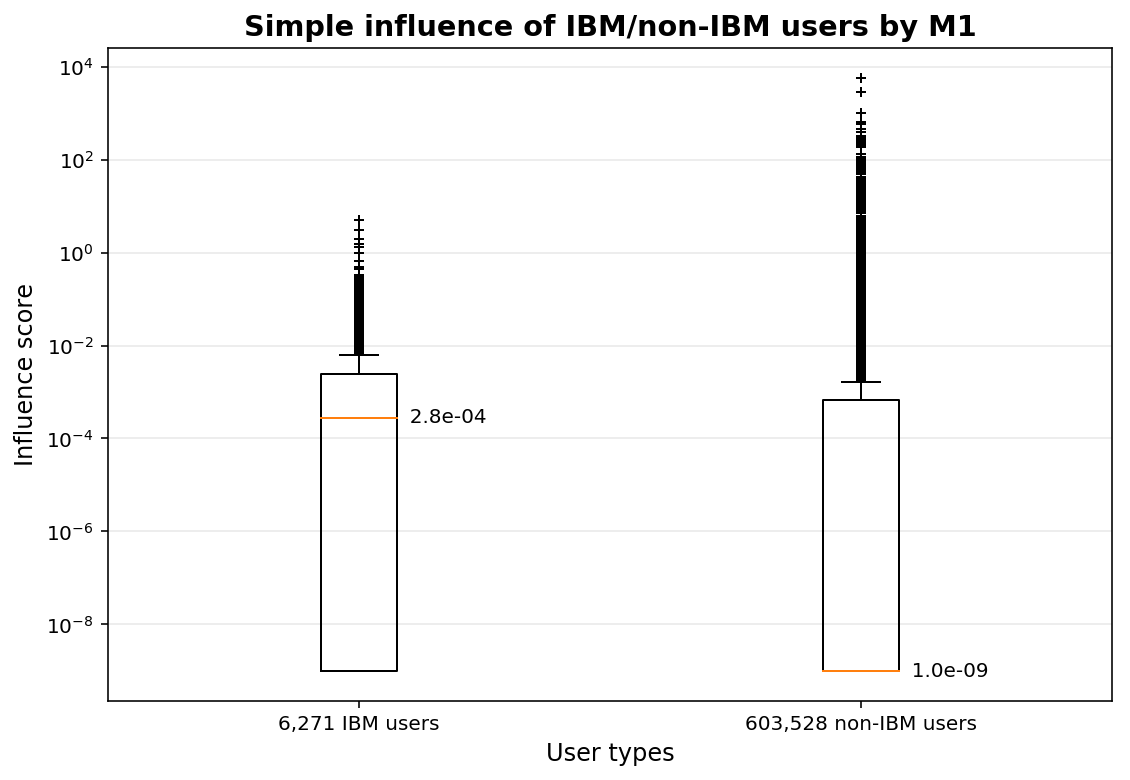

In [12]:
"""
Plot simple influence for IBM/non-IBM users based on M1
"""

simple_influence_m1_fig = os.path.join(FIG_DIR, 'simple_influence_m1.png')

if 1 == 1:
    '''
    Prepare data
    '''
    # IBM users
    m1_ibm_norm_s = df_user_nt_ibm_desc['fo'] * df_user_nt_ibm_desc['n_n']
    m1_ibm_norm_s = m1_ibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m1_ibm_simple_influence = df_user_nt_ibm_desc['n_src'] / m1_ibm_norm_s
    
    # non-IBM users
    m1_nonibm_norm_s = df_user_nt_nonibm_desc['fo'] * df_user_nt_nonibm_desc['n_n']
    m1_nonibm_norm_s = m1_nonibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m1_nonibm_simple_influence = df_user_nt_nonibm_desc['n_src'] / m1_nonibm_norm_s
    
    # limit the minimum influence value
    # otherwise, small enough influence value result in negative infinity in log scale
    m1_ibm_simple_influence[m1_ibm_simple_influence < 1e-9] = 1e-9
    m1_nonibm_simple_influence[m1_nonibm_simple_influence < 1e-9] = 1e-9
    
    data = [m1_ibm_simple_influence, m1_nonibm_simple_influence]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    ax.set_xticklabels(['6,271 IBM users', '603,528 non-IBM users'])
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('Simple influence of IBM/non-IBM users by M1', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('User types', fontdict=label_fontdict)
    ax.set_ylabel('Influence score', fontdict=label_fontdict)
    ax.set_yscale('log')
        
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, ' {:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(simple_influence_m1_fig, dpi=200)

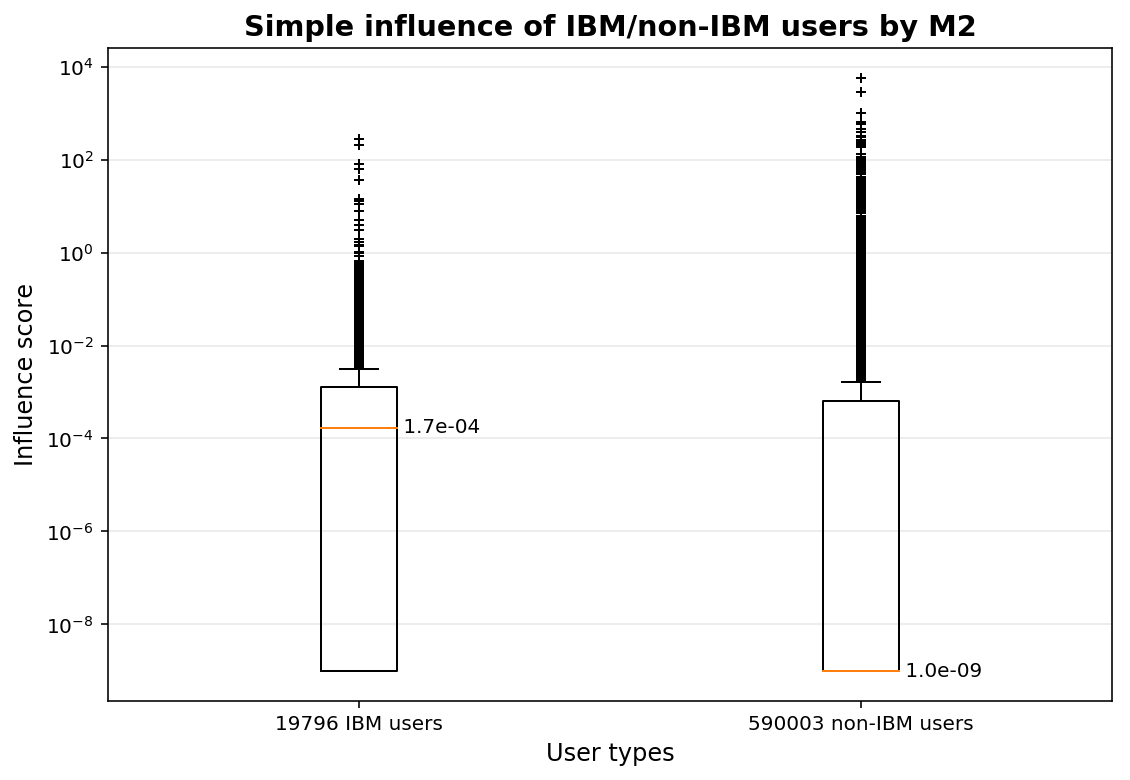

In [5]:
"""
Plot simple influence for IBM/non-IBM users based on M2
"""

simple_influence_m2_fig = os.path.join(FIG_DIR, 'simple_influence_m2.png')

if 1 == 1:
    '''
    Prepare data
    '''
    # IBM users
    ibm_users_num = df_user_nt_ibm_tw_prop_2.shape[0]
    
    m2_ibm_norm_s = df_user_nt_ibm_tw_prop_2['fo'] * df_user_nt_ibm_tw_prop_2['n_n']
    m2_ibm_norm_s = m2_ibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m2_ibm_simple_influence = df_user_nt_ibm_tw_prop_2['n_src'] / m2_ibm_norm_s
    
    # non-IBM users
    nonibm_users_num = df_user_nt_nonibm_tw_prop_2.shape[0]
    
    m2_nonibm_norm_s = df_user_nt_nonibm_tw_prop_2['fo'] * df_user_nt_nonibm_tw_prop_2['n_n']
    m2_nonibm_norm_s = m2_nonibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m2_nonibm_simple_influence = df_user_nt_nonibm_tw_prop_2['n_src'] / m2_nonibm_norm_s
    
    # limit the minimum influence value
    # otherwise, small enough influence value result in negative infinity in log scale
    m2_ibm_simple_influence[m2_ibm_simple_influence < 1e-9] = 1e-9
    m2_nonibm_simple_influence[m2_nonibm_simple_influence < 1e-9] = 1e-9

    data = [m2_ibm_simple_influence, m2_nonibm_simple_influence]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    ax.set_xticklabels(['{} IBM users'.format(ibm_users_num), '{} non-IBM users'.format(nonibm_users_num)])
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('Simple influence of IBM/non-IBM users by M2', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('User types', fontdict=label_fontdict)
    ax.set_ylabel('Influence score', fontdict=label_fontdict)
    ax.set_yscale('log')
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

    '''
    Save figure
    '''
    plt.savefig(simple_influence_m2_fig, dpi=200)

# Notes

Issues:
1. Both the distribution of 'retweet_count' and the distribution 'followers_count' are high skewed.
2. There are other information useful: 'favorite_count' of tweet...
3. Do not differentiate between influence on IBM users or influence on non-IBM users.